# [Basic Interactive Geospatial Analysis in Python](http://blog.yhat.com/posts/interactive-geospatial-analysis.html)
by Piero Ferrante | June 30, 2016

About Piero: Piero Ferrante is the Director of Data Science at [C2FO](https://c2fo.com/). He and his team are focused on optimizing C2FO’s capital markets through applied machine learning and developing contemporary quantitative risk management systems. Piero also enjoys teaching, rowing, and hacking on open data. You can find him on [Twitter](https://twitter.com/the_real_pdf) and [LinkedIn](https://www.linkedin.com/in/piero-ferrante-53510691).

## Intro
Geospatial analysis is a massive field with a rich history. Python has some pretty slick packages for working with geospatial data such as, but not limited to, Shapeley, Fiona, and Descartes.

GeoPandas sits on top of these packages and exposes a familiar Pandas-like API that makes a series of element-wise and aggregation methods (from the base packages) easy to apply to dataframes containing geometry data. From the GeoPandas repo:

> "GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

> GeoPandas geometry operations are cartesian. The coordinate reference system (crs) can be stored as an attribute on an object, and is automatically set when loading from a file. Objects may be transformed to new coordinate systems with the to_crs() method. There is currently no enforcement of like coordinates for operations, but that may change in the future."




<img src="geo-panda-design.png"> 

Note The image above has no association with the GeoPandas project, although it would be pretty cool if it did. It's called the 'Geometric Hipster Panda' and was found [here](http://www.bluelotusmedia.com/geometric-hipster-panda).

We'll run through a basic example analysis detailing the following:

- How to create a GeoDataFrame from a shape file
- Plotting GeoDataFrames
- A couple helpful operations for performing faster point-in-polygon calculations
- Simulating spatial, temporal user data
- And a few nifty Jupyter widgets, magic functions, and add-ins along the way

## Setup


In [18]:
!pip install -q show geopandas tqdm ipython-autotime
!pip show geopandas tqdm ipython-autotime

Name: geopandas
Version: 0.3.0
Summary: Geographic pandas extensions
Home-page: http://geopandas.org
Author: GeoPandas contributors
Author-email: kjordahl@alum.mit.edu
License: BSD
Location: /home/bri/anaconda2/lib/python2.7/site-packages
Requires: shapely, descartes, pandas, pyproj, fiona
---
Name: tqdm
Version: 4.23.0
Summary: Fast, Extensible Progress Meter
Home-page: https://github.com/tqdm/tqdm
Author: Noam Yorav-Raphael
Author-email: noamraph@gmail.com
License: MPLv2.0, MIT Licences
Location: /home/bri/anaconda2/lib/python2.7/site-packages
Requires: 
---
Name: ipython-autotime
Version: 0.1
Summary: Time everything in IPython
Home-page: https://github.com/cpcloud/ipython-autotime
Author: Phillip Cloud
Author-email: cpcloud@gmail.com
License: BSD
Location: /home/bri/anaconda2/lib/python2.7/site-packages
Requires: 


In [19]:
# basic stuff
import os
import pandas as pd
import numpy as np
from random import randint, uniform
from datetime import datetime
from urllib import urlretrieve
from zipfile import ZipFile

# geo stuff
import geopandas as gpd
from shapely.geometry import Point
# from ipyleaflet import (Map,
#     Marker,
#     TileLayer, ImageOverlay,
#     Polyline, Polygon, Rectangle, Circle, CircleMarker,
#     GeoJSON,
#     DrawControl
# )

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

# progress stuff
from tqdm import tqdm_notebook, tqdm_pandas
%load_ext autotime

# turn warnings off
import warnings
warnings.filterwarnings('ignore')


## Helper function for retrieving NYC borough shape file


In [20]:
def get_nyc_shape_file(url, filename):

    # download file
    zipped = filename + '.zip'
    urlretrieve('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile', zipped)
    zipped = os.getcwd() + '/' + zipped

    # unzip file
    to_unzip = ZipFile(zipped, 'r')
    unzipped = os.getcwd() + '/' + filename + '_unzipped'
    to_unzip.extractall(unzipped)
    to_unzip.close()

    # get shape file
    for file in os.listdir(unzipped):
        if file.endswith(".shp"):
            shape_file =  unzipped + '/' + file

    # return full file path
    return shape_file


time: 11.4 ms


In [21]:
# get shape file path
shape_file_url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
shape_file_dir = 'nyc_boroughs'
file_path = get_nyc_shape_file(shape_file_url,shape_file_dir)


time: 26.7 s


## Creating GeoDataFrames is simple


In [22]:
# read and view GeoDataFrame
gdf = gpd.GeoDataFrame.from_file(file_path)
gdf.head()

,boro_name,shape_area,boro_code,shape_leng,geometry
0,Staten Island,1.623921e+09,5.0,330432.865440,(POLYGON ((-74.05050806403247 40.5664220341608...
1,Manhattan,6.366004e+08,1.0,361657.416718,(POLYGON ((-74.01092841268031 40.6844914725429...
2,Bronx,1.186619e+09,2.0,463454.790585,(POLYGON ((-73.89680883223774 40.7958084451597...
3,Brooklyn,1.937567e+09,3.0,739945.556630,(POLYGON ((-73.86706149472118 40.5820879767934...
4,Queens,3.044772e+09,4.0,895232.757777,(POLYGON ((-73.83668274106707 40.5949466970158...


time: 874 ms


## Plotting too!


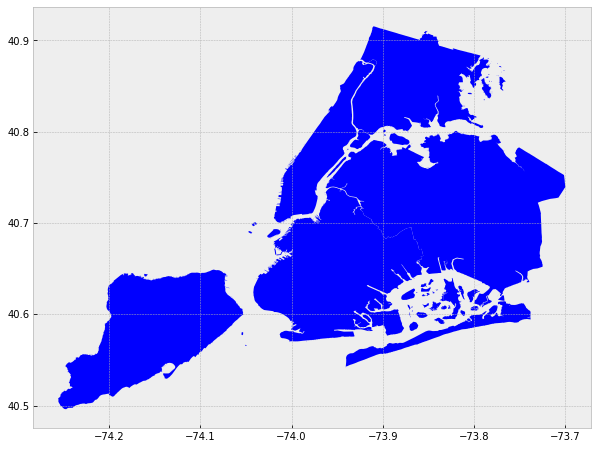

time: 343 ms


In [25]:
# plot GeoDataFrame
gdf.plot()


Now we'll use some of GeoPandas powerful methods to simplify our geometry (I'll explain why we're doing this later)


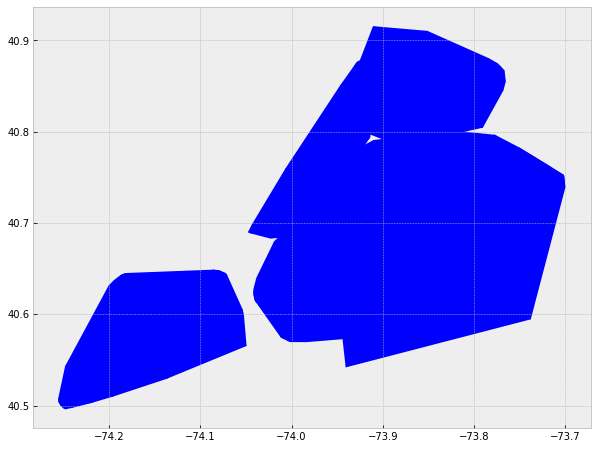

time: 299 ms


In [26]:
# create convex hulls
hulls = gdf['geometry'].convex_hull

# plot overlay
hulls.plot(ax=gdf.plot())


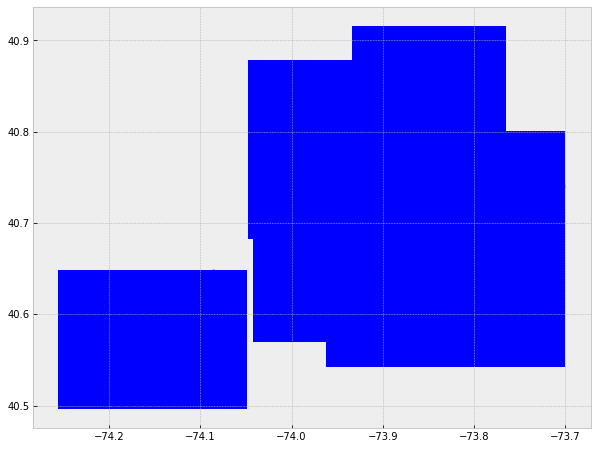

time: 269 ms


In [27]:
# create envelopes
envelope = gpd.GeoSeries(hulls.envelope)

# plot overlay
envelope.plot(ax=gdf.plot())


## Cool! Now let's simulate some user data...

We're also using tqdm's integrated Jupyter functionality to update a progress var.

Note: you may need to enable the Jupyter Javascript widget, which you can do by running: `jupyter nbextension enable --py --sys-prefix widgetsnbextension`



In [30]:
def sim_users(n, p, f):

    # create datetime range
    today = datetime.today().strftime("%m/%d/%Y")
    rng = pd.date_range(today, periods=p, freq=f)

    # get min/max coorindates
    min_x, min_y = gdf['geometry'].bounds.ix[:,:2].min()
    max_x, max_y = gdf['geometry'].bounds.ix[:,2:].max()

    # iterate over time datetime range and create user list
    sim_user_list = []
    for ts in tqdm_notebook(rng, desc='Progress', leave=True):
        for j in xrange(n):
            x = uniform(min_x, max_x)
            y = uniform(min_y, max_y)
            point = Point(x, y)
            gender = randint(0, 1)
            sim_user_list.append([ts, x, y, point, gender])

    # return dataframe
    sim_user_df = pd.DataFrame(sim_user_list, columns=['datetime', 'x', 'y', 'point', 'gender'])
    return sim_user_df

# simulate user data
sim_data = sim_users(100, 24, 'H')
sim_data.head()


HBox(children=(IntProgress(value=0, description=u'Progress', max=24), HTML(value=u'')))

,datetime,x,y,point,gender
0,2018-04-17,-73.850662,40.803274,POINT (-73.85066208569643 40.8032741792408),1
1,2018-04-17,-73.948246,40.914152,POINT (-73.94824622425287 40.91415178330914),1
2,2018-04-17,-74.169248,40.772688,POINT (-74.16924803595838 40.7726880512816),1
3,2018-04-17,-74.207281,40.882881,POINT (-74.20728066484729 40.88288066908257),0
4,2018-04-17,-73.877224,40.632252,POINT (-73.8772244740245 40.63225246013963),1


time: 168 ms


## And plot...


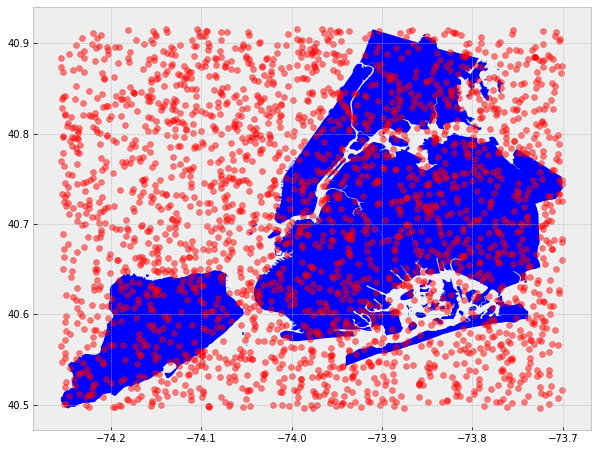

time: 369 ms


In [31]:
# plot simulated data points
gdf.plot()
plt.scatter(x=sim_data['x'], y=sim_data['y'], alpha=0.5, c='r')


Now suppose we wanted to see which of those user points fell in different NYC boroughs. A simple solution would be to use a point-in-polygon (PIP) calculation to determine if a given point is contained within a given geometry (like Queens). This can become pretty computationally expensive if the geometry in question is complex, which most are. A reasonable solution, if absolute precision is not a requirement, would be to simplify the aforementioned geometry and in turn simplify the PIP calculation.

Let's compare the runtime for calculating a PIP boolean value for any of the 5 boroughs using the actual geometry, convex hulls, and envelopes with the user data that we just simulated.

Note: I should point out that point-in-polygon indexing will not scale well. This is where geohashes and quadtrees are of tremendous use, but are also outside the scope of this blog post.



In [32]:
# check if point(s) fall within known geometry - actual
sim_data['contains_1'] = sim_data['point'].map(lambda x: True if gdf.contains(x).any()==True else False)


time: 13.3 s


In [33]:
# check if point(s) fall within known geometry - convex hulls
sim_data['contains_2'] = sim_data['point'].map(lambda x: True if hulls.contains(x).any()==True else False)

time: 535 ms


In [34]:
# check if point(s) fall within known geometry - envelopes
sim_data['contains_3'] = sim_data['point'].map(lambda x: True if envelope.contains(x).any()==True else False)


time: 494 ms


That's about a 90x and 160x speed up respectively! It's clear that greater precision comes at a significantly higher computational cost.

Create a widget to visualize users moving over time


In [35]:
def make_plot(hour=1):

    # filter dataframe
    temp = sim_data[sim_data['contains_2']==True]
    temp=temp[temp['datetime'].dt.hour==hour]

    # plot
    hulls.plot(ax=gdf.plot())
    plt.scatter(x=temp['x'], y=temp['y'], s=30)

# create widget
interact(make_plot, hour=(1, 23, 1))


interactive(children=(IntSlider(value=1, description=u'hour', max=23, min=1), Output()), _dom_classes=('widget-interact',))

<function __main__.make_plot>

time: 372 ms


That's all folks! Hope this was helpful intro to doing basic geospatial analysis in Python.

Other helpful links:

- PyData NYC conference [video](https://vimeo.com/79535664) from GeoPandas creator Kelsey Jordahl
- [ipyleaflet](https://github.com/ellisonbg/ipyleaflet) - A Jupyter / Leaflet bridge enabling interactive maps in the Jupyter notebook